#  Modelo de FitzHugh-Nagumo

El modelo de FitzHugh - Nagumo (FHN) describe un prototipo de sistema excitable como una neurona.  Toma su nombre de Richard FitzHugh (1922 - 2007), quien propuso el modelo teórico en 1961, así como de J. Nagumo y otros, que construyeron un circuito electrónico equivalente.

$$ \dfrac{dv}{dt} = v - \dfrac{v^3}{3}-w+RI_{\text{ext}} $$
$$\tau \dfrac{dw}{dt} = v + a - bw $$

Aquí el parámetro a variar es $I_{\text{ext}}$ para analizar los diagramas de bifurcación y los puntos de estabilidad.



In [1]:
R = 1.0
a = 0.7
b = 0.8
τ = 12.5;

Para linealizar las ecuaciones, buscamos los casos donde $\dfrac{dv}{dt} = 0$ y $\dfrac{dw}{dt} = 0$. Entonces

$$v - \dfrac{v^3}{3}-w+RI_{\text{ext}} = 0 \Rightarrow w = v - \dfrac{v^3}{3} +RI_{\text{ext}} $$
$$v + a - bw = 0 \Rightarrow w = \dfrac{v + a}{b}$$

Tenemos una curva y una recta intersectando. Esa intersección la encontramos con el método de Newton-Raphson. Aquí, llamaremos la isoclina cúbica a $w = v - \dfrac{v^3}{3} +RI_{\text{ext}}$ y la isoclina lineal a $w = \dfrac{v + a}{b}$.

In [2]:
using LinearAlgebra, Plots

In [3]:
isoclina_cubica(v,I_ext) = -v^3/3 + v + R*I_ext

isoclina_lineal(v) = (v + a) / b

inters(v,I_ext) = -v^3/3 +(1-1/b)*v + R*I_ext - a/b #isoclina_cubica - isoclina_lineal

dinters(v) = -v^2 + 1 - 1/b;

In [4]:
function NewtonRaphson(f, df, I_ext, v0; tol=1e-16, max = 1000)
    v = v0
    w = f(v0,I_ext)
    i = 0
    while abs(w) > tol && i < max
        v = v  - w/df(v)
        w = f(v,I_ext)
        i += 1
    end
    return v
end

NewtonRaphson (generic function with 1 method)

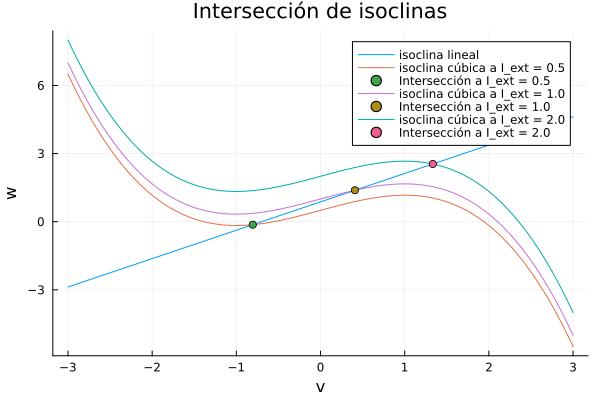

In [5]:
V = -3:0.05:3
I_list = [0.5,1.0,2.0]
intersecciones = plot(V,isoclina_lineal.(V), label = "isoclina lineal",ylabel = "w", xlabel ="v", title ="Intersección de isoclinas")

for i in I_list
    v_cero = NewtonRaphson(inters, dinters, i, 0.0 ; tol=1e-16, max = 1000)
    plot!(V,isoclina_cubica.(V,i), label = "isoclina cúbica a I_ext = $(i)")
    scatter!((v_cero,isoclina_lineal(v_cero)), label = "Intersección a I_ext = $(i)")
end

savefig(intersecciones, "intersecciones.png")
display(intersecciones)
    

Ahora, llamamos $(v^{*},w^{*})$ al punto donde ambas derivadas se hacen cero, es decir, 

$$f(v^{*},w^{*}) = \dfrac{dv}{dt}(v^{*},w^{*}) = 0$$
$$g(v^{*},w^{*}) = \dfrac{dw}{dt}(v^{*},w^{*}) = 0$$

Hacemos un desarrollo de Taylor de este punto.

$$f(v,w) = f(v^{*},w^{*}) + \left.\dfrac{\partial f}{\partial v}\right|_{(v^{*},w^{*})}(v - v^{*}) + \left.\dfrac{\partial f}{\partial w}\right|_{(v^{*},w^{*})}(w - w^{*}) + ...$$
$$g(v,w) = g(v^{*},w^{*}) + \left.\dfrac{\partial g}{\partial v}\right|_{(v^{*},w^{*})}(v - v^{*}) + \left.\dfrac{\partial g}{\partial w}\right|_{(v^{*},w^{*})}(w - w^{*}) + ...$$

Y linealizamos en valores cercanos al punto $(v^{*},w^{*})$

$$\begin{pmatrix}
\dfrac{dv}{dt} \\
\dfrac{dw}{dt} 
\end{pmatrix} =\begin{pmatrix}
f(v,w) \\
g(v,w)
\end{pmatrix} = 
\begin{pmatrix}
\left.\dfrac{\partial f}{\partial v}\right|_{(v^{*},w^{*})}(v - v^{*}) + \left.\dfrac{\partial f}{\partial w}\right|_{(v^{*},w^{*})}(w - w^{*})\\
\left.\dfrac{\partial g}{\partial v}\right|_{(v^{*},w^{*})}(v - v^{*}) + \left.\dfrac{\partial g}{\partial w}\right|_{(v^{*},w^{*})}(w - w^{*})
\end{pmatrix} = 
\begin{pmatrix}
\left.\dfrac{\partial f}{\partial v}\right|_{(v^{*},w^{*})} & \left.\dfrac{\partial f}{\partial w}\right|_{(v^{*},w^{*})}\\
\left.\dfrac{\partial g}{\partial v}\right|_{(v^{*},w^{*})} & \left.\dfrac{\partial g}{\partial w}\right|_{(v^{*},w^{*})}
\end{pmatrix} \begin{pmatrix}
v-v^{*}\\
w-w^{*}
\end{pmatrix}
$$

$$\begin{pmatrix}
\dfrac{dv}{dt} \\
\dfrac{dw}{dt} 
\end{pmatrix} = \begin{pmatrix}
A & B \\
C & D
\end{pmatrix} \begin{pmatrix}
\Delta v\\
\Delta w
\end{pmatrix} = \lambda_{1,2} \begin{pmatrix}
\Delta v\\
\Delta w
\end{pmatrix}
$$

Usaremos la funcion `LinearAlgebra.eigen(A)` para calcular los eigenvalores del Jacobiano, donde:

$$A = \left.\dfrac{\partial f}{\partial v}\right|_{(v^{*},w^{*})} = -{v^{*}}^{2} + 1$$
$$B = \left.\dfrac{\partial f}{\partial w}\right|_{(v^{*},w^{*})} = -1$$
$$C = \left.\dfrac{\partial g}{\partial v}\right|_{(v^{*},w^{*})} = \dfrac{1}{\tau}$$
$$D = \left.\dfrac{\partial g}{\partial w}\right|_{(v^{*},w^{*})} = -\dfrac{b}{\tau}$$

In [6]:
"""
    λ = Eigenvalores(I_ext::Float64)

Los argmentos de esta funcion son `I_ext` que es la corriente externa del sistema.

Esta función devuelve `λ::Vector{Float64}` con la parte real de los 2 eigenvalores del modelo de FitzHugh-Nagumo a un `I_ext` determinado.
"""
function Eigenvalores(I_ext::Float64)
    
    v_cero = NewtonRaphson(inters, dinters,I_ext, -1.0; tol=1e-20, max = 1000)
    
    A = -v_cero^2 + 1
    B = -1
    C =  1/τ
    D = -b/τ
    M = [A B;
         C D]
    λ = real.(eigen(M).values)
    if abs(inters(v_cero,I_ext)) <= 1e-15
        return λ
    else
        return [NaN for i in 1:length(λ)] #Este caso es cuando el método de Newton-Raphson no converge, para no graficarlo.
    end
end;

In [7]:
"""
    I_bifurcacion = bifurcacion(I_ini::Float64; ΔI = 1.0)

Esta función devuelve la corriente de bifurcación a presición de maquina. Tiene como argumentos una corriente de partida `I_ini` y un salto predeterminado de `ΔI = 1.0`.
"""
function bifurcacion(I_ini; ΔI = 1.0)

    I_ext = I_ini
    for i in 1:20
        I_ext += ΔI
        λ1, λ2 = Eigenvalores(I_ext)
        Δλ = abs(λ1 - λ2)
        j = 0
        while Δλ == 0 && j < 1000
            I_ext += ΔI
            λ1, λ2 = Eigenvalores(I_ext)
            Δλ = abs(λ1 - λ2)
            j += 1
        end
        I_ext -= ΔI
        ΔI = ΔI/10
    end
    return I_ext
end;

In [8]:
function bifurcacion(I_ini::Float64,I_bif::Vector{Float64})
    if (I_ini < I_bif[1]) || (I_bif[2] < I_ini < I_bif[3]) || I_ini > I_bif[4]
        return true
    else
        return false
    end
end

bifurcacion (generic function with 2 methods)

In [9]:
I_bif_pos = bifurcacion.([0.0,1.87];ΔI = 1.0)
I_bif_neg = bifurcacion.([0.0,1.87];ΔI = -1.0)
I_bif = I_bif_pos ∪ I_bif_neg
I_bif = sort(I_bif)
println("Primer bifurcación: $(I_bif[1])")
println("Segunda bifurcación: $(I_bif[2])")
println("Tercera bifurcación: $(I_bif[3])")
println("Cuarta bifurcación: $(I_bif[4])");

Primer bifurcación: -0.1376285942198854
Segunda bifurcación: 0.5812657551242898
Tercera bifurcación: 1.16873424487571
Cuarta bifurcación: 1.8876285942198845


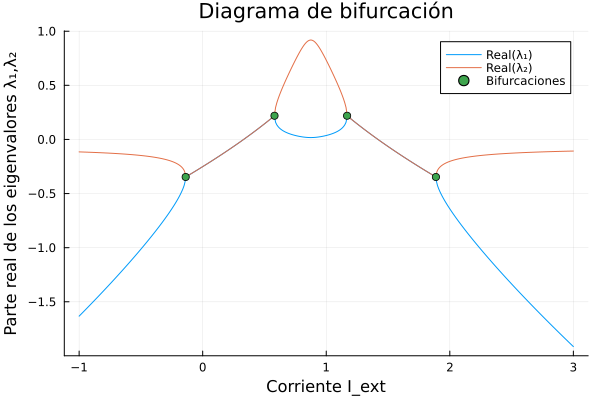

In [10]:
I_ext = -1.0:0.01:3.0

Λ = Eigenvalores.(I_ext)
Λ1 = [λ[1] for λ in Λ]
Λ2 = [λ[2] for λ in Λ]

plot_bif = plot(I_ext, Λ1, label = "Real(λ₁)", xlabel = "Corriente I_ext", ylabel = "Parte real de los eigenvalores λ₁,λ₂")
plot!(I_ext, Λ2, label = "Real(λ₂)", title = "Diagrama de bifurcación")
scatter!([(i, Eigenvalores(i)[1]) for i in I_bif], label = "Bifurcaciones")
savefig(plot_bif, "bifurcación.png")
display(plot_bif)

Ahora que conocemos los puntos de bifurcación, observemos la solucioón al sistema con $I_{ext}$ en las zonas de bifurcación y de no bifurcación.

In [11]:
include("Librerias\\integracion_taylor.jl");
using .IntegTaylor

In [12]:
function f!(du,u,p,t)
    du[1] = u[1] - u[1]^3/3 - u[2] + p[1]*p[2]
    du[2] = (u[1] + p[3] - p[4]*u[2])/p[5]
end

f! (generic function with 1 method)

In [13]:
v0 = 1.0
w0 = 0.2
u0 = [v0,w0]

t_ini = 0.0
t_fin = 100.0

orden = 20
ϵ = 1e-20;

In [14]:
function sol_FHN(I_ext)
    p = [R,I_ext,a,b,τ]
    t, u = try 
        integracion_taylor(f!,u0,t_ini,t_fin,orden,ϵ,p)
    catch 
        [[NaN], [[NaN for i in 1:length(u0)]]]
    end
    v = [uu[1] for uu in u]
    w = [uu[2] for uu in u]
    plot1 = plot(v,w,label="Neurona", xlabel = "Voltaje de membrana v", ylabel = "Variable de recuperación w")
    title!("Diagrama de fase del modelo FHN \n I_ext = $(I_ext) | Bifurcación = $(bifurcacion(I_ext, I_bif))")
    plot2 = plot(t,v,label = "I_ext = $(I_ext)", xlabel = "Tiempo t", ylabel = "Voltaje de membrana v")
    title!("Voltaje de membrana contra tiempo\n I_ext = $(I_ext) | Bifurcación = $(bifurcacion(I_ext, I_bif))")
    plot3 = plot(t,w,label = "I_ext = $(I_ext)", xlabel = "Tiempo t", ylabel = "Variable de recuperación w")
    title!("Variable de recuperación contra tiempo\n I_ext = $(I_ext) | Bifurcación = $(bifurcacion(I_ext, I_bif))")
    return plot1, plot2, plot3
end

sol_FHN (generic function with 1 method)

In [15]:
I_list = -1.0:0.02:3.0

DF = [plot() for i in 1:length(I_list)]
V = [plot() for i in 1:length(I_list)]
W = [plot() for i in 1:length(I_list)]

for i in 1:length(I_list)
    plot1, plot2, plot3 = sol_FHN(I_list[i])
    DF[i] = plot1
    V[i] = plot2
    W[i] = plot3
    if mod(i,10) == 0
        println("I_ext = $(I_list[i])")
    end
end;

I_ext = -0.82
I_ext = -0.62
I_ext = -0.42
I_ext = -0.22
I_ext = -0.02
I_ext = 0.18
I_ext = 0.38
I_ext = 0.58
I_ext = 0.78
I_ext = 0.98
I_ext = 1.18
I_ext = 1.38
I_ext = 1.58
I_ext = 1.78
I_ext = 1.98
I_ext = 2.18
I_ext = 2.38
I_ext = 2.58
I_ext = 2.78
I_ext = 2.98


I_ext = -0.82
I_ext = -0.62
I_ext = -0.42
I_ext = -0.22
I_ext = -0.02
I_ext = 0.18
I_ext = 0.38
I_ext = 0.58
I_ext = 0.78
I_ext = 0.98
I_ext = 1.18
I_ext = 1.38
I_ext = 1.58
I_ext = 1.78
I_ext = 1.98
I_ext = 2.18
I_ext = 2.38
I_ext = 2.58
I_ext = 2.78
I_ext = 2.98


[ Info: Saved animation to C:\Users\cocol\Desktop\ProyectoFinal_TSFC2\FHN.gif


Plots.AnimatedGif("C:\\Users\\cocol\\Desktop\\ProyectoFinal_TSFC2\\FHN.gif")
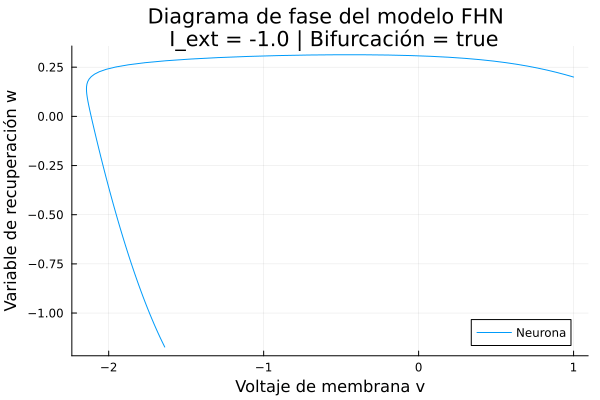

In [16]:
anim = @animate for i in 1:length(I_list)
    plot(DF[i])
    if mod(i,10) == 0
        println("I_ext = $(I_list[i])")
    end
end

gif(anim,"FHN.gif", fps = 5)

I_ext = -0.82
I_ext = -0.62
I_ext = -0.42
I_ext = -0.22
I_ext = -0.02
I_ext = 0.18
I_ext = 0.38
I_ext = 0.58
I_ext = 0.78
I_ext = 0.98
I_ext = 1.18
I_ext = 1.38
I_ext = 1.58
I_ext = 1.78
I_ext = 1.98
I_ext = 2.18
I_ext = 2.38
I_ext = 2.58
I_ext = 2.78
I_ext = 2.98


[ Info: Saved animation to C:\Users\cocol\Desktop\ProyectoFinal_TSFC2\V.gif


Plots.AnimatedGif("C:\\Users\\cocol\\Desktop\\ProyectoFinal_TSFC2\\V.gif")
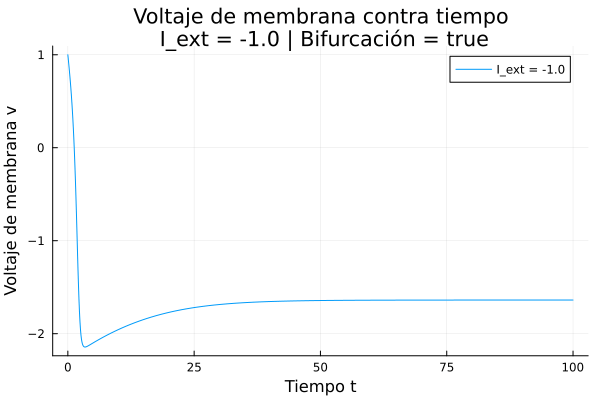

In [17]:
anim = @animate for i in 1:length(I_list)
    plot(V[i])
    if mod(i,10) == 0
        println("I_ext = $(I_list[i])")
    end
end

gif(anim,"V.gif", fps = 5)

I_ext = -0.82
I_ext = -0.62
I_ext = -0.42
I_ext = -0.22
I_ext = -0.02
I_ext = 0.18
I_ext = 0.38
I_ext = 0.58
I_ext = 0.78
I_ext = 0.98
I_ext = 1.18
I_ext = 1.38
I_ext = 1.58
I_ext = 1.78
I_ext = 1.98
I_ext = 2.18
I_ext = 2.38
I_ext = 2.58
I_ext = 2.78
I_ext = 2.98


[ Info: Saved animation to C:\Users\cocol\Desktop\ProyectoFinal_TSFC2\W.gif


Plots.AnimatedGif("C:\\Users\\cocol\\Desktop\\ProyectoFinal_TSFC2\\W.gif")
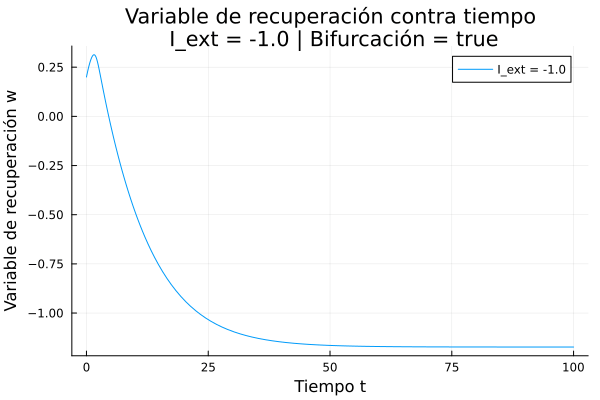

In [18]:
anim = @animate for i in 1:length(I_list)
    plot(W[i])
    if mod(i,10) == 0
        println("I_ext = $(I_list[i])")
    end
end

gif(anim,"W.gif", fps = 5)

Referencias

- Kaplan, D., & Glass, L. (1997). Understanding nonlinear dynamics. Springer Science & Business Media.
- Rocsoreanu, C., Georgescu, A., & Giurgiteanu, N. (2012). The FitzHugh-Nagumo model: bifurcation and dynamics (Vol. 10). Springer Science & Business Media.